In [1]:
# 📊 Brand Impact on Price Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("car_data.csv")
df_clean = df.dropna()

print(f"Data loaded: {len(df_clean)} records")
print(f"Brands: {df_clean['car_brand'].nunique()}")
print(f"Price range: £{df_clean['car_price'].min():,.0f} - £{df_clean['car_price'].max():,.0f}")


Data loaded: 42089 records
Brands: 112
Price range: £7,000 - £69,999,999


In [2]:
# Load + Clean + Align columns
import pandas as pd
import numpy as np

CURRENT_YEAR = 25

df_raw = pd.read_csv("car_data.csv")

rename_map = {
    'car_brand': 'Manufacturer',
    'car_model': 'Model',
    'car_price': 'Price',
    'car_fuel': 'Fuel type',
    'car_mileage': 'Mileage',
    'car_engine_capacity': 'Engine size',
    'car_engine_hp': 'Engine HP',
    'car_age': 'Age',
               
}
df = df_raw.rename(columns=rename_map).copy()


for c in ['Manufacturer','Model','Fuel type']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# ensure numeric types
for c in ['Price','Mileage','Engine size','Engine HP','Age']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df['Year of manufacture'] = CURRENT_YEAR - df['Age']

# 3) drop NaNs on required cols
req = ['Manufacturer','Model','Fuel type','Price','Mileage','Engine size','Engine HP','Year of manufacture','Age']
df = df.dropna(subset=[c for c in req if c in df.columns]).reset_index(drop=True)

# 4) light outlier clipping (IQR on Price)
Q1, Q3 = df['Price'].quantile(0.25), df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 3*IQR, Q3 + 3*IQR
df = df[(df['Price'] >= lower) & (df['Price'] <= upper)].reset_index(drop=True)

# 5) extra features used later
df['Mileage_per_year'] = df['Mileage'] / df['Age'].replace(0, 1)
df['Depreciation_Factor'] = df['Age'] / (df['Age'] + 1)
df['Age_x_Mileage'] = df['Age'] * df['Mileage']
df['Log_Mileage'] = np.log1p(df['Mileage'])
df['Log_Age'] = np.log1p(df['Age'])

# Engine-related features
df['hp_per_liter'] = df['Engine HP'] / df['Engine size'].replace(0, 1)
df['log_hp'] = np.log1p(df['Engine HP'])
df['hp_per_year'] = df['Engine HP'] / df['Age'].replace(0, 1)

print(df.head(3))
print(df.dtypes)
print(f"Clean rows: {len(df)}")

   Unnamed: 0   Manufacturer      Model    Price   car_city Fuel type  \
0           0           Ford      Focus   550000  Astrakhan  gasoline   
1           1  Mercedes-Benz  GLA-Class  1820000  Astrakhan  gasoline   
2           2          Haval         F7  2600000  Astrakhan  gasoline   

  car_transmission car_drive  Mileage car_country  ...  Age  \
0           manual       FWD   300000         USA  ...   14   
1            robot       FWD    88000          DE  ...   10   
2            robot       4WD    19000          CN  ...    2   

   Year of manufacture  Mileage_per_year  Depreciation_Factor  Age_x_Mileage  \
0                   11      21428.571429             0.933333        4200000   
1                   15       8800.000000             0.909091         880000   
2                   23       9500.000000             0.666667          38000   

   Log_Mileage   Log_Age  hp_per_liter    log_hp  hp_per_year  
0    12.611541  2.708050     69.444444  4.836282     8.928571  
1    

In [3]:
# KNN with StandardScaler + OneHot on aligned columns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

numeric_features = [
    'Age','Mileage','Engine size','Engine HP','Mileage_per_year',
    'Log_Mileage','Log_Age','Age_x_Mileage','Depreciation_Factor',
    'hp_per_liter','log_hp','hp_per_year'
]
cat_features = ['Manufacturer','Model','Fuel type']

use_num = [c for c in numeric_features if c in df.columns]
use_cat = [c for c in cat_features if c in df.columns]

X = df[use_num + use_cat].copy()
y = df['Price'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), use_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=20, sparse_output=False), use_cat)
    ],
    remainder='drop'
)

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsRegressor(weights='distance', p=1)) 
])

param_grid = {
    'knn__n_neighbors': [5,7,9,11,13,15,17,21,25,31,35]
}

gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

best = gs.best_estimator_
y_pred = best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best params:", gs.best_params_)
print(f"MAE: £{mae:,.2f}")
print(f"RMSE: £{rmse:,.2f}")
print(f"R²: {r2:.4f}")

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best params: {'knn__n_neighbors': 9}
MAE: £179,497.13
RMSE: £296,740.75
R²: 0.9263


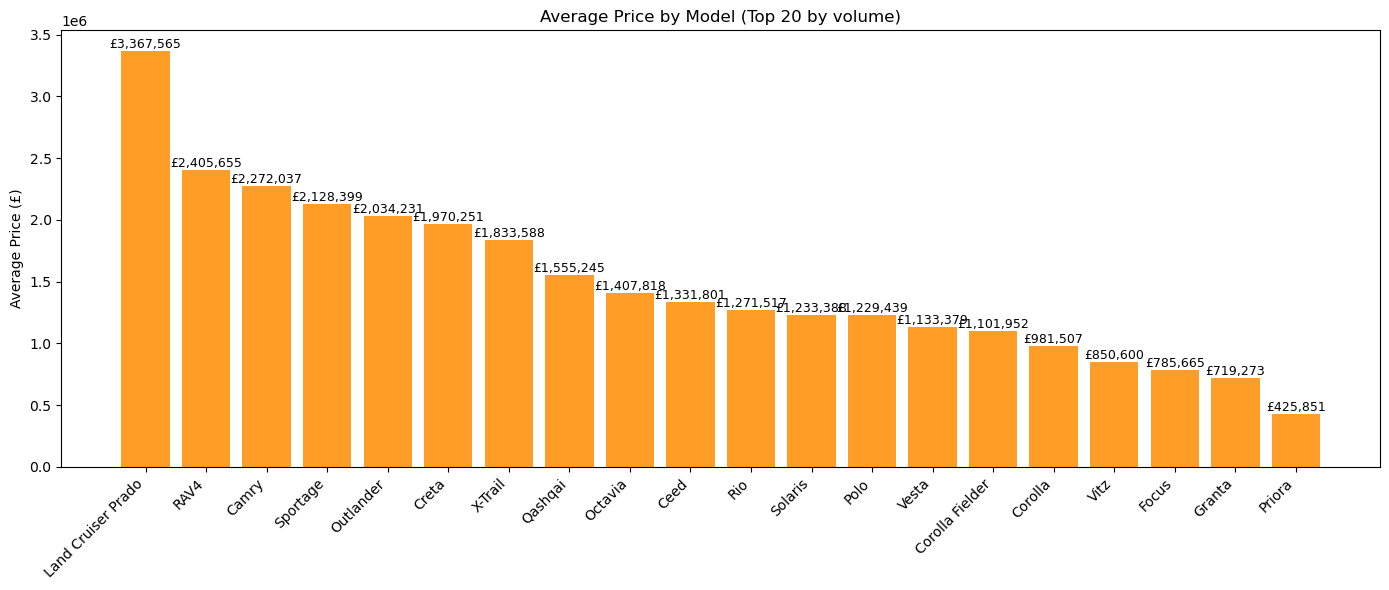

In [4]:
# Model vs Price (Top 20 by sample size to reduce noise)
import pandas as pd
import matplotlib.pyplot as plt

df_clean = df.dropna(subset=['Manufacturer','Model','Price'])

top_models = (df_clean['Model'].value_counts().head(20).index)
model_avg = (df_clean[df_clean['Model'].isin(top_models)]
             .groupby('Model')['Price'].mean().sort_values(ascending=False))

plt.figure(figsize=(14,6))
bars = plt.bar(model_avg.index, model_avg.values, color='darkorange', alpha=0.85)
plt.ylabel('Average Price (£)')
plt.title('Average Price by Model (Top 20 by volume)')
plt.xticks(rotation=45, ha='right')

# add labels
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f'£{h:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_vs_price_bar.png', dpi=300, bbox_inches='tight')
plt.show()

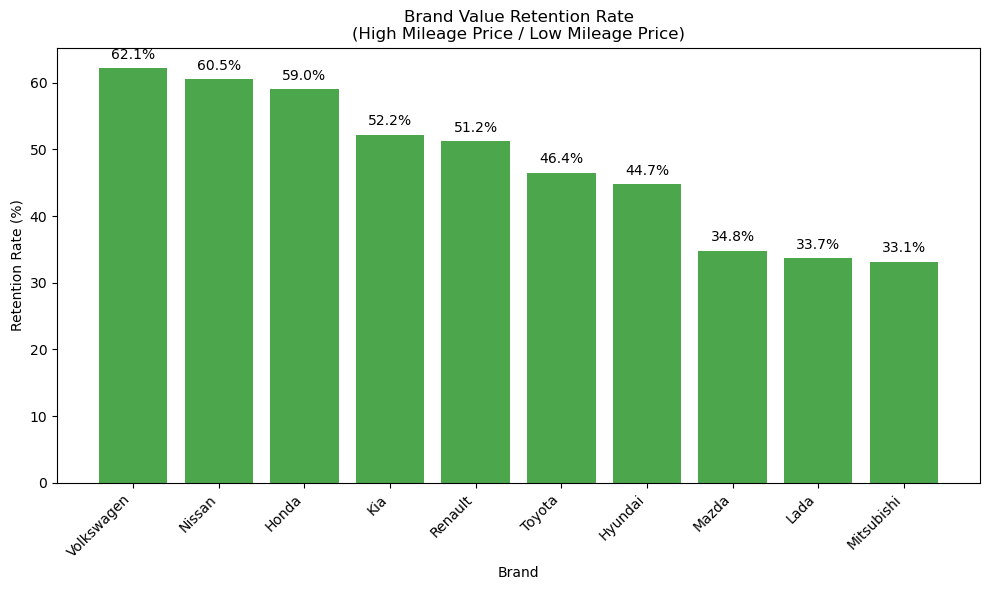

In [5]:
# Brand value retention analysis
def calculate_value_retention(df, brand):
    brand_data = df[df['Manufacturer'] == brand]
    
    low_mileage = brand_data[brand_data['Mileage'] <= 50000]['Price'].median()
    high_mileage = brand_data[brand_data['Mileage'] >= 100000]['Price'].median()
    
    if pd.isna(low_mileage) or pd.isna(high_mileage) or low_mileage == 0:
        return None
    
    retention_rate = (high_mileage / low_mileage) * 100
    return retention_rate

brands_with_enough_data = df_clean['Manufacturer'].value_counts().head(10).index
retention_data = []

for brand in brands_with_enough_data:
    retention = calculate_value_retention(df_clean, brand)
    if retention is not None:
        retention_data.append({'Brand': brand, 'Retention_Rate': retention})

retention_df = pd.DataFrame(retention_data).sort_values('Retention_Rate', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(retention_df['Brand'], retention_df['Retention_Rate'], 
               color='green', alpha=0.7)
plt.title('Brand Value Retention Rate\n(High Mileage Price / Low Mileage Price)')
plt.xlabel('Brand')
plt.ylabel('Retention Rate (%)')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('brand_value_retention_rate.png', dpi=300, bbox_inches='tight')
plt.show()

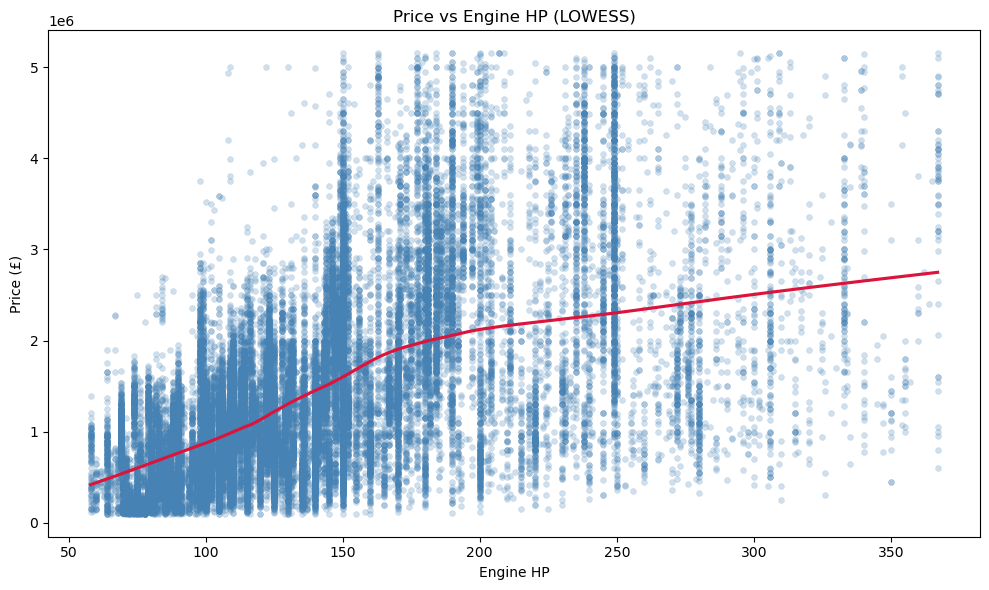

In [6]:
# Single chart: Price vs Engine HP (with LOWESS)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

PRICE_COL = 'Price'

plot_df = df.dropna(subset=['Engine HP', PRICE_COL]).copy()
# Light clipping to reduce extreme outlier influence on trend
hp_lo, hp_hi = plot_df['Engine HP'].quantile([0.01, 0.99])
pr_lo, pr_hi = plot_df[PRICE_COL].quantile([0.01, 0.99])
plot_df = plot_df[(plot_df['Engine HP'].between(hp_lo, hp_hi)) & (plot_df[PRICE_COL].between(pr_lo, pr_hi))]

plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='Engine HP', y=PRICE_COL, alpha=0.25, s=18, color='steelblue', edgecolor=None)
sns.regplot(data=plot_df, x='Engine HP', y=PRICE_COL, scatter=False, lowess=True, color='crimson')
plt.title('Price vs Engine HP (LOWESS)')
plt.xlabel('Engine HP')
plt.ylabel('Price (£)')
plt.tight_layout()
plt.savefig('price_vs_engine_hp.png', dpi=300, bbox_inches='tight')
plt.show()


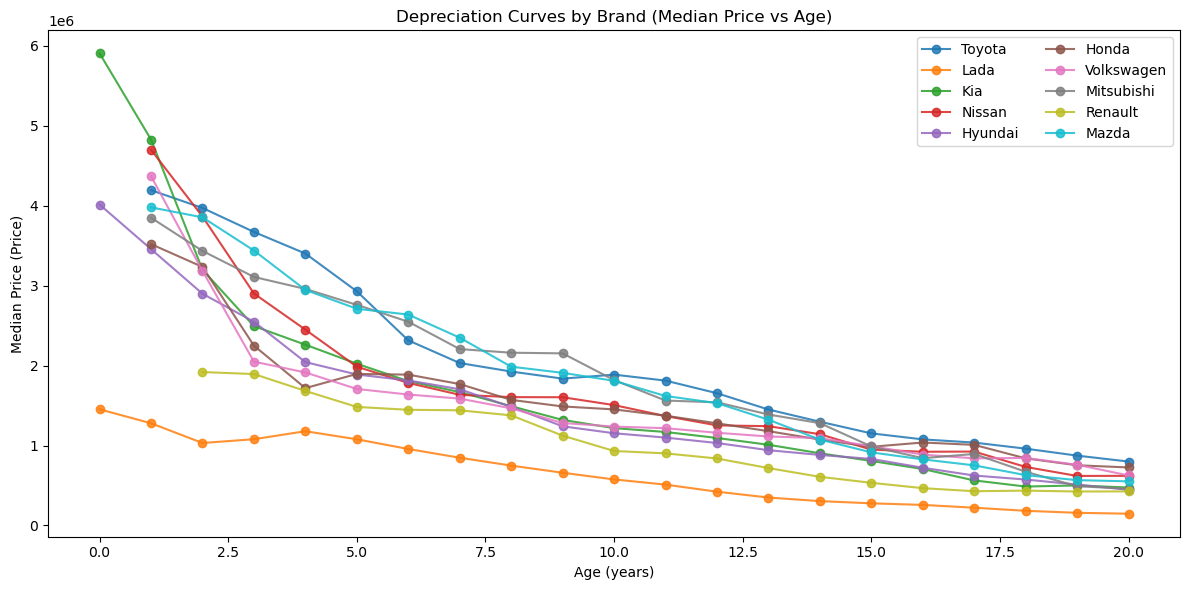

In [7]:
# Depreciation curves: Median Price vs Age, by Brand (Top 10)
import matplotlib.pyplot as plt
import pandas as pd

PRICE_COL = 'Price'

need_cols = ['Manufacturer', 'Year of manufacture', PRICE_COL]
df_b = df.dropna(subset=need_cols).copy()

top_brands = df_b['Manufacturer'].value_counts().head(10).index
df_b = df_b[df_b['Manufacturer'].isin(top_brands)]

CURRENT_YEAR = 25
df_b['Age'] = CURRENT_YEAR - df_b['Year of manufacture']
df_b = df_b[(df_b['Age'] >= 0) & (df_b['Age'] <= 20)]

med_curve = (df_b.groupby(['Manufacturer','Age'])[PRICE_COL]
               .median().reset_index())

def smooth_group(g, win=2):
    g = g.sort_values('Age').copy()
    g['Price_smooth'] = g[PRICE_COL].rolling(window=win, min_periods=1, center=True).median()
    return g
med_curve = med_curve.groupby('Manufacturer', as_index=False).apply(smooth_group).reset_index(drop=True)

plt.figure(figsize=(12,6))
for b in top_brands:
    d = med_curve[med_curve['Manufacturer']==b].sort_values('Age')
    if len(d) > 1:
        plt.plot(d['Age'], d['Price_smooth'], marker='o', alpha=0.85, label=b)

plt.xlabel('Age (years)')
plt.ylabel(f'Median Price ({PRICE_COL})')
plt.title('Depreciation Curves by Brand (Median Price vs Age)')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('brand_depreciation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

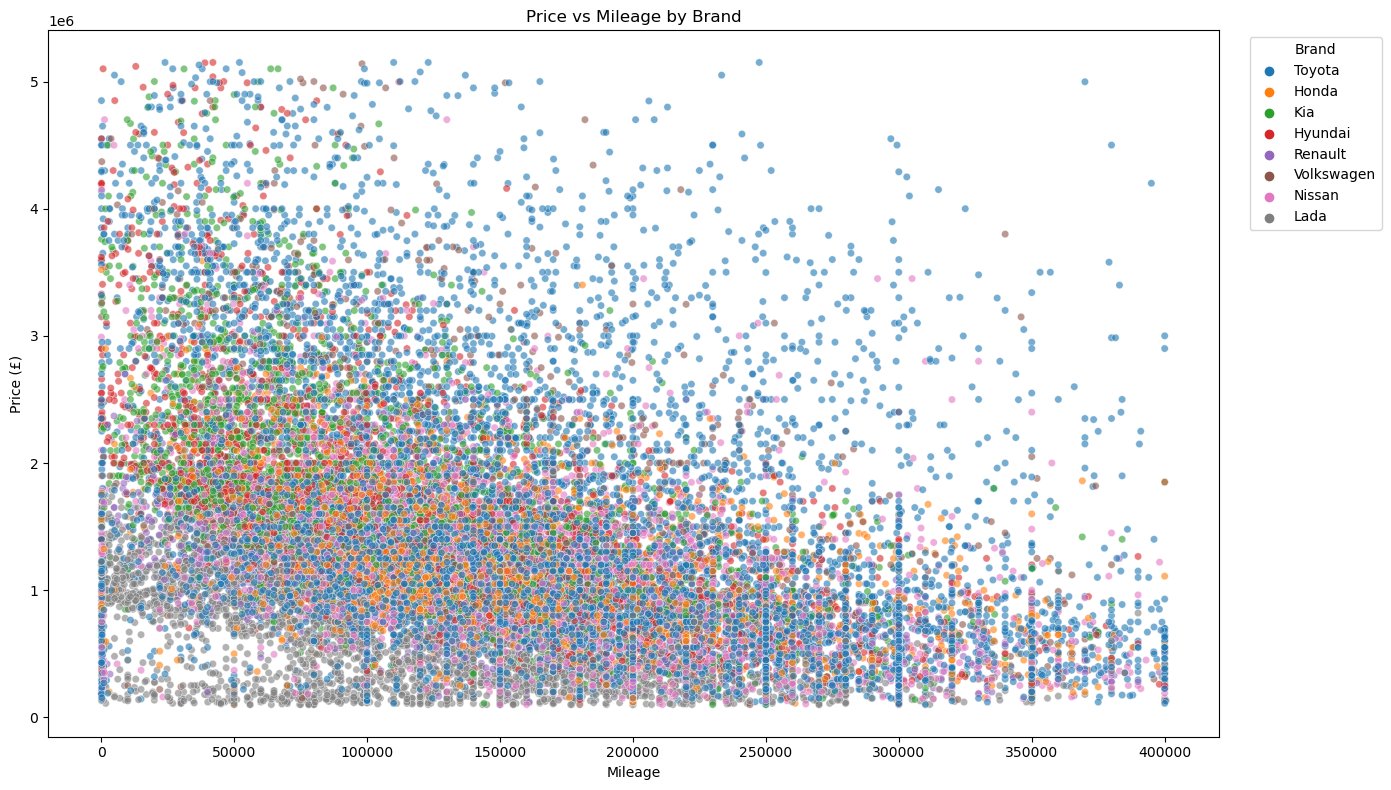

In [10]:
# Price vs Mileage by Brand (rewritten)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

PRICE_COL = 'Price'

m_df = df.dropna(subset=['Mileage', PRICE_COL, 'Manufacturer']).copy()

# Light outlier clipping for readability
mi_lo, mi_hi = m_df['Mileage'].quantile([0.01, 0.99])
pr_lo, pr_hi = m_df[PRICE_COL].quantile([0.01, 0.99])
m_df = m_df[m_df['Mileage'].between(mi_lo, mi_hi) & m_df[PRICE_COL].between(pr_lo, pr_hi)]

# Top brands by volume
top_brands = m_df['Manufacturer'].value_counts().head(8).index
plot_df = m_df[m_df['Manufacturer'].isin(top_brands)]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=plot_df, x='Mileage', y=PRICE_COL,
    hue='Manufacturer', alpha=0.6, s=28
)
plt.title('Price vs Mileage by Brand')
plt.xlabel('Mileage')
plt.ylabel('Price (£)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Brand')
plt.tight_layout()
plt.savefig('mileage_vs_price_by_brand_v2.png', dpi=300, bbox_inches='tight')
plt.show()